In [1]:

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('btcmindata.csv')
df['time'] = pd.to_datetime(df.time, unit='ms')
df.columns = ['datetime','open','close','high','low','volume']

df.set_index('datetime',inplace=True)
df.to_csv('btcmindata.csv')
df


,open,close,high,low,volume
datetime,,,,,
2013-04-01 00:07:00,93.25,93.30,93.30,93.25,93.300000
2013-04-01 00:08:00,100.00,100.00,100.00,100.00,93.300000
2013-04-01 00:09:00,93.30,93.30,93.30,93.30,33.676862
2013-04-01 00:11:00,93.35,93.47,93.47,93.35,20.000000
2013-04-01 00:12:00,93.47,93.47,93.47,93.47,2.021627
...,...,...,...,...,...
2023-02-11 14:59:00,21757.00,21759.00,21760.00,21757.00,12.120300
2023-02-11 15:00:00,21755.00,21762.00,21762.00,21755.00,0.014166
2023-02-11 15:01:00,21761.00,21753.00,21761.00,21752.00,0.010103


In [3]:
def dynamic_stop_profit(df, lookback, vol_multiplier, stop_loss, profit_target, z_threshold):
    # Compute the rolling mean and standard deviation
    rolling_mean = df['close'].rolling(window=lookback).mean()
    rolling_std = df['close'].rolling(window=lookback).std()

    # Compute the z-score
    z_score = (df['close'] - rolling_mean) / rolling_std

    # Compute the average true range
    true_range = df['high'] - df['low']
    atr = true_range.rolling(window=lookback).mean()

    # Compute the stop loss and profit target
    stop_loss_dyn = atr * vol_multiplier * stop_loss
    profit_target_dyn = atr * vol_multiplier * profit_target

    # Create a signal when the z-score is above or below the threshold
    signal = np.zeros(len(z_score))
    signal[z_score > z_threshold] = -1
    signal[z_score < -z_threshold] = 1

    # Compute the returns
    returns = np.log(df['close'] / df['close'].shift(1))

    # Apply the signal to the returns to get the strategy returns
    strategy_returns = signal * returns.shift(-1)

    # Compute the trailing stop loss
    stop_loss_trail = np.zeros(len(strategy_returns))
    for i in range(1, len(stop_loss_trail)):
        if signal[i-1] > 0:
            stop_loss_trail[i] = max(df['low'][i-1], stop_loss_trail[i-1] - stop_loss_dyn[i])
        elif signal[i-1] < 0:
            stop_loss_trail[i] = min(df['high'][i-1], stop_loss_trail[i-1] + stop_loss_dyn[i])
        else:
            stop_loss_trail[i] = 0

    # Compute the take profit level
    take_profit = np.zeros(len(strategy_returns))
    for i in range(1, len(take_profit)):
        if signal[i-1] > 0:
            take_profit[i] = df['close'][i-1] * (1 + profit_target_dyn[i])
        elif signal[i-1] < 0:
            take_profit[i] = df['close'][i-1] * (1 - profit_target_dyn[i])
        else:
            take_profit[i] = 0

    # Update the positions based on the trailing stop loss and take profit level
    new_positions = np.zeros(len(strategy_returns))
    for i in range(1, len(new_positions)):
        if signal[i-1] > 0 and (df['close'][i] <= stop_loss_trail[i] or df['close'][i] >= take_profit[i]):
            new_positions[i] = 0
        elif signal[i-1] < 0 and (df['close'][i] >= stop_loss_trail[i] or df['close'][i] <= take_profit[i]):
            new_positions[i] = 0
        else:
            new_positions[i] = signal[i]

    strategy_returns = new_positions * returns.shift(-1)

    # Compute the cumulative returns
    cumulative_returns = strategy_returns.cumsum()

    # Plot the cumulative returns
    plt.plot(cumulative_returns)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title('Mean Reversion Strategy with Z-Score, Dynamic Stop Loss, and Profit Target')
    plt.show
    # Compute the Sharpe ratio
    sharpe_ratio = np.sqrt(252) * np.mean(strategy_returns) / np.std(strategy_returns)
    print(f'Sharpe Ratio: {sharpe_ratio}')

    return cumulative_returns, sharpe_ratio



Sharpe Ratio: -0.22071260583612914
Sharpe Ratio: -0.22071260583612914


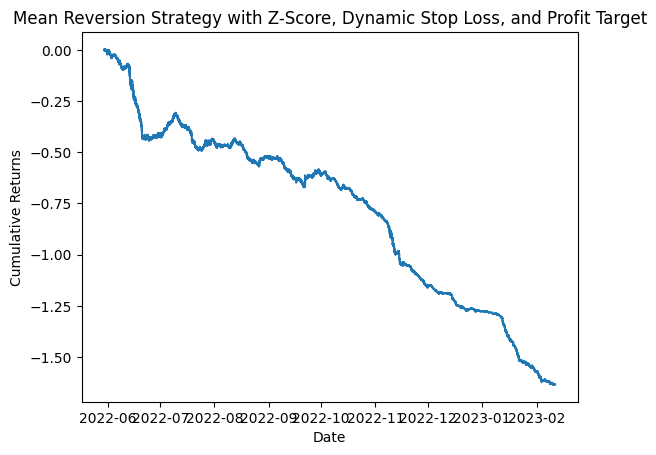

In [4]:
# Load the data
df = pd.read_csv('btcmindata.csv', index_col=0)
df = df.reset_index()
#df.index = pd.to_datetime(df.index)
df.datetime = pd.to_datetime(df.datetime)
mask = (df['datetime'] > '2022-05-30 00:07:00') & (df['datetime'] <= '2023-02-11 15:03:00')
df = df.loc[mask]
df.set_index('datetime',inplace=True)

# Define the lookback period, z-score threshold, and stop loss/profit target parameters
lookback = 20
z_threshold = .9
stop_loss = 0.02
profit_target = 0.1
vol_multiplier = .03

# Call the dynamic_stop_profit function with the input data and parameters
cumulative_returns, sharpe_ratio = dynamic_stop_profit(df, lookback, vol_multiplier, stop_loss, profit_target, z_threshold)

# Print the Sharpe ratio
print(f'Sharpe Ratio: {sharpe_ratio}')

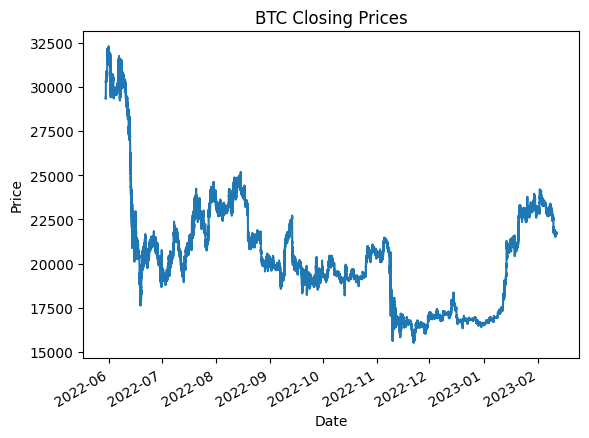

In [5]:
# Plot the closing prices
df['close'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Closing Prices')
plt.show()


In [ ]:
# def take_profit_level(df, positions, profit_target):
#     # Compute the take profit level
#     take_profit = np.zeros(len(positions))
#     for i in range(1, len(take_profit)):
#         if positions[i-1] > 0:
#             take_profit[i] = df['close'][i-1] * (1 + profit_target)
#         elif positions[i-1] < 0:
#             take_profit[i] = df['close'][i-1] * (1 - profit_target)
#         else:
#             take_profit[i] = 0

#     # Update the positions based on the take profit level
#     new_positions = np.zeros(len(positions))
#     for i in range(1, len(new_positions)):
#         if positions[i-1] > 0 and df['close'][i] >= take_profit[i]:
#             new_positions[i] = 0
#         elif positions[i-1] < 0 and df['close'][i] <= take_profit[i]:
#             new_positions[i] = 0
#         else:
#             new_positions[i] = positions[i]

#     return new_positions

In [ ]:
# def trailing_stop_loss(df, positions, stop_loss):
#     # Compute the trailing stop loss
#     stop_loss_trail = np.zeros(len(positions))
#     for i in range(1, len(stop_loss_trail)):
#         if positions[i-1] > 0:
#             stop_loss_trail[i] = max(df['low'][i-1], stop_loss_trail[i-1] - stop_loss)
#         elif positions[i-1] < 0:
#             stop_loss_trail[i] = min(df['high'][i-1], stop_loss_trail[i-1] + stop_loss)
#         else:
#             stop_loss_trail[i] = 0

#     # Update the positions based on the trailing stop loss
#     new_positions = np.zeros(len(positions))
#     for i in range(1, len(new_positions)):
#         if positions[i-1] > 0 and df['close'][i] <= stop_loss_trail[i]:
#             new_positions[i] = 0
#         elif positions[i-1] < 0 and df['close'][i] >= stop_loss_trail[i]:
#             new_positions[i] = 0
#         else:
#             new_positions[i] = positions[i]

#     return new_positions